# ElectroStatic Solver 2

This notebook shows the obtention of electrostatic forces on a boundary due to the application of a high voltage.

It finds the electrostatic forces inside FeniCs, solving an auxiliary variational problem. It returns the forces and points where the forces must be applied


In [ ]:
#Setup FeniCs, must run in Colab

!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
import dolfin
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

In [1]:
pip install meshio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import meshio
#Use this lines if you wish import your mesh as a msh (GMSH) file
msh2 = meshio.read("NSlev.msh")
meshio.write("NSlev.xml",msh2)
mesh = Mesh("NSlev.xml")

In [ ]:
 #Solves Poisson Equation in order to get electric potential at every point
from dolfin import *
import meshio
#Define parameters for simplicity
#This block of code provides a general mesh case, it can be modified in accordance to the problem needed

originx = 0
originy = 0
origin = Point(originx,originy)

bigRectx = 10
bigRecty = 5
bigRect = Point(bigRectx, bigRecty)

rect2_1x = 4
rect2_1y = 2
rect2_1 = Point(rect2_1x,rect2_1y)

rect2_2x = 6
rect2_2y = 5
rect2_2 = Point(rect2_2x,rect2_2y)


rect1 = Rectangle(origin, bigRect)
rect2 = Rectangle(rect2_1, rect2_2)
circle = Circle(Point(5 , 2), 1 )

domain = rect1 - rect2 - circle
mesh = generate_mesh(domain, 100)


"""msh = meshio.read("NSlev.xml")
mesh = Mesh("NSlev.xml")"""

V = FunctionSpace(mesh, 'CG', 1)

v_0 = Constant(0) #Defines ground
v_2 = Constant(13500) #Voltage that is applied to the needle

def bottom_side(x, on_boundary): #Defines the boundary for the collector
    if (near(x[1], 0) )  and on_boundary:
        return True

def voltage(x,on_boundary): #Defines the boudary on which there is a voltage is applied. Aka, the needle
  Bool = False
  if on_boundary:
    if ((near(x[1],0) or near(x[0],0) or near(x[0],10) or near(x[1],5))): #Change these values for the boundaries of the mesh used.
      return Bool
    else:
      return True

bot_bc = DirichletBC(V, v_0, bottom_side)
drop_bc = DirichletBC(V, v_2, voltage)
bcs = [bot_bc, drop_bc] #Creates Dirichlet conditions for the electrostatic potential

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
a = dot(grad(u), grad(v))*dx #Define variational form for Poissons equation
L = f*v*dx #Define variational form

u = Function(V)
solve(a == L, u, bcs) #Solve linear system for the potential (u)

a  = plot(u , title = "Trial simulation") #Plot solution (if needed)
cbar = plt.colorbar(a)
cbar.ax.set_ylabel('Voltage applied [V]')

In [ ]:
import numpy as np

#Define E in terms of the gradient of the electric potential

E = project(-grad(u), VectorFunctionSpace(mesh, 'CG', 1)) #Projection, in order to get to obtain E (vectorfield)
EX, EY = E.split(deepcopy=True)  # extract components

b = plot(E, title="Electric Field around needle") #Plot E
cbar = plt.colorbar(b)
cbar.ax.set_ylabel('Electric Field [V/m]')

# Add grid and axis number lines
plt.grid(True)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')


file = File("Eiter1.pvd") #Save the value of E for visualization in Paraview
file << E


In [7]:
# Define Maxwell Stress tensor (M) according to Riva's definition, all within FeniCs environment
epsilon = 8.85E-12

M = -0.5 * epsilon * dot(E, E) * Identity(2) +  epsilon*outer(E, E)



In [19]:
#This variational problem solves for the normal vectors on the boundary of the needle
n = FacetNormal(mesh)
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(u,v)*ds
l = inner(n, v)*ds
A = assemble(a, keep_diagonal=True)
L = assemble(l)

A.ident_zeros()
nh = Function(V)

def n_is_cero(x,on_boundary): #Define the places where the normal vector should be cero
  if on_boundary:
    if ((near(x[1],0) or near(x[0],0) or near(x[0],10) or near(x[1],5))): #Change according to the boundaries for your problem
      return True
    else:
      return False


drop_bc = DirichletBC(V, Constant((0,0)), n_is_cero)

bcs = [drop_bc]

[bc.apply(A) for bc in bcs] #Apply boundary conditions to A
[bc.apply(L) for bc in bcs]


solve(A, nh.vector(),L) #Find nh (normal vectors). Note that they may need to be multiplied by -1, in order to
Faux = dot(M,-nh) #Value for the electrostatic force over the whole domain (We are only interested on the boundary)
F = project(F, VectorFunctionSpace(mesh, 'CG', 1))

In [38]:
#Block of code used to extract the values for the nodes at the boundary
class boundary(SubDomain):
    def inside(self, x, on_boundary): #Define a subdomain of the mesh, only with the nodes where the following conditions are met
      if on_boundary:
        if near(x[0], 0) or near(x[0], 10) or near(x[1],0) or near(x[1],5) or near(x[0], 0.4) or near(x[0], 0.6): #Change according to the boundaries for your problem
          return False
        else:
          return True
      else:
        return False


V = FunctionSpace(mesh, "CG", 1)
mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary().mark(mf, 1) #Mark the elements of the desired boundary
v2d = vertex_to_dof_map(V)
dofs = []

for facet in facets(mesh): #Obtain a list of the marked nodes
    if mf[facet.index()] == 1:
        vertices = facet.entities(0)
        for vertex in vertices:
            dofs.append(v2d[vertex])

unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
boundary_coords = V.tabulate_dof_coordinates()[unique_dofs]

forces = [0]*len(boundary_coords)

for i in range(0,len(boundary_coords)):
  arr = boundary_coords[i]
  forces[i] = F([arr[0] , arr[1]])

<ipython-input-39-54e6301fb202>:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')


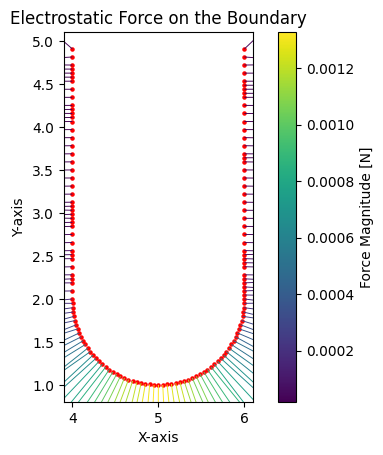

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

#Function used to visualize the
def plot_points_and_vectors(points, vectors):
    fig, ax = plt.subplots()

    # Normalize vectors to make them unitary
    norms = np.linalg.norm(vectors, axis=1)
    unit_vectors = vectors / norms[:, np.newaxis]

    # Use a color map to represent vector magnitudes
    magnitudes = np.linalg.norm(vectors, axis=1)
    norm = Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
    colors = cm.viridis(norm(magnitudes))

    # Define your custom scaling factor
    custom_scaling_factor = 10 #Length of the vectors

    # Plot points
    ax.scatter(*zip(*points), color='red', s=5)

    for i, point in enumerate(points):
      vector = custom_scaling_factor * unit_vectors[i]  # Adjust the length
      color = cm.viridis(norm(magnitudes[i]))

      scale = 0.001
      line_width = 0.005  # Set your desired line width here

      ax.quiver(point[0], point[1], vector[0], vector[1], angles='xy', scale_units='xy', scale=1,
                color=color, width=line_width, edgecolor=color)

    ax.set_aspect('equal')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Electrostatic Force on the Boundary')

    # Resize the grid
    plt.grid(True, linewidth=0.05, alpha=0.005)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', label='Force Magnitude [N]')

    plt.show()


plot_points_and_vectors(boundary_coords, forces)
